In [1]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from preprocess import load_data, inform

In [2]:
full, train, test, val = load_data()

Loading cached files.


In [3]:
print("Full data:")
inform(full)
print("Training data:")
inform(train)
print("Test data:")
inform(test)
print("Validation data:")
inform(val)

Full data:
Shape of data: (49312, 5)
There are 91.30% 0 values in column 'Actiware classification'.
There are 91.74 0 values in column 'Actiwatch activity counts'.
Training data:
Shape of data: (39209, 4)
There are 92.63% 0 values in column 'Actiware classification'.
There are 99.07 0 values in column 'Actiwatch activity counts'.
Test data:
Shape of data: (6543, 4)
There are 90.63% 0 values in column 'Actiware classification'.
There are 98.81 0 values in column 'Actiwatch activity counts'.
Validation data:
Shape of data: (2146, 4)
There are 93.90% 0 values in column 'Actiware classification'.
There are 98.93 0 values in column 'Actiwatch activity counts'.


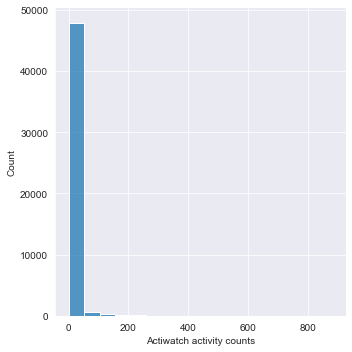

In [4]:
sns.displot(full, x="Actiwatch activity counts")